# 1. Install Dependencies and Setup


In [1]:
# !pip install tensorflow opencv-python
# tensorflow-gpu matplotlib

In [2]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data


### 2.1 Load Images


In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files(
    "data/train_aug/images/*.jpg", shuffle=False)
# train_images = tf.data.Dataset.list_files('data\\train_aug\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x / 255)

2024-04-26 12:43:05.472993: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-26 12:43:05.473023: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-26 12:43:05.473031: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-26 12:43:05.473090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 12:43:05.473272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
test_images = tf.data.Dataset.list_files(
    "data/test_aug/images/*.jpg", shuffle=False)

# test_images = tf.data.Dataset.list_files('data\\test_aug\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x / 255)

In [7]:
# 720 pics
val_images = tf.data.Dataset.list_files(
    "data/val_aug/images/*.jpg", shuffle=False)

# val_images = tf.data.Dataset.list_files('data\\val_aug\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x / 255)

### 2.2 Prepare Labels


In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
    return [label["keypoints"]]

In [9]:
train_labels = tf.data.Dataset.list_files(
    "data/train_aug/labels/*.json", shuffle=False)
train_labels = train_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.float16])
)

In [10]:
train_labels.as_numpy_iterator().next()
# x left eye, y left eye, x right eye, y right eye

(array([0.4058, 0.6274, 0.6143, 0.6265], dtype=float16),)

In [11]:
test_labels = tf.data.Dataset.list_files(
    "data/test_aug/labels/*.json", shuffle=False)
test_labels = test_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files(
    "data/val_aug/labels/*.json", shuffle=False)
val_labels = val_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images


In [13]:
# train: 1410 pics
# test: 810 pics
# val: 720 pics

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1600)
train = train.batch(16)
train = train.prefetch(4)

In [15]:
train.as_numpy_iterator().next()

(array([[[[6.99358404e-01, 5.18966258e-01, 5.18966258e-01],
          [6.91879213e-01, 5.19330204e-01, 5.15408635e-01],
          [6.90423548e-01, 5.17874479e-01, 5.13952911e-01],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[6.96392179e-01, 5.16000032e-01, 5.16000032e-01],
          [6.88421965e-01, 5.15872955e-01, 5.11951387e-01],
          [6.86666667e-01, 5.14117658e-01, 5.10196090e-01],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[6.96784317e-01, 5.16392171e-01, 5.16392171e-01],
          [6.86564744e-01, 5.14015734e-01, 5.10094166e-01],
          [6.87411726e-01, 5.14862716e-01, 5.10941148e-01],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

In [16]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(900)
test = test.batch(16)
test = test.prefetch(4)

In [17]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(800)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples


In [18]:
data_samples = train.as_numpy_iterator()

In [19]:
res = data_samples.next()

In [20]:
res

(array([[[[7.07529426e-01, 6.56549037e-01, 5.89882374e-01],
          [7.11058855e-01, 6.60078466e-01, 5.93411803e-01],
          [7.08156884e-01, 6.57176495e-01, 5.90509832e-01],
          ...,
          [8.27223539e-01, 7.60556877e-01, 6.97811782e-01],
          [8.26431453e-01, 7.59764791e-01, 6.97019696e-01],
          [8.32691789e-01, 7.66025126e-01, 7.03280032e-01]],
 
         [[7.08120763e-01, 6.57140374e-01, 5.90473711e-01],
          [7.08784342e-01, 6.57803953e-01, 5.91137290e-01],
          [7.10721552e-01, 6.47976458e-01, 5.85231364e-01],
          ...,
          [8.27349007e-01, 7.60682344e-01, 6.97937250e-01],
          [8.26696515e-01, 7.60029852e-01, 6.97284758e-01],
          [8.31372559e-01, 7.64705896e-01, 7.01960802e-01]],
 
         [[7.13725507e-01, 6.62745118e-01, 5.96078455e-01],
          [7.20549047e-01, 6.57803953e-01, 5.95058858e-01],
          [7.13764668e-01, 6.51019573e-01, 5.88274479e-01],
          ...,
          [8.27803910e-01, 7.61137247e-01, 6.9839

In [21]:
res[0].shape

(16, 250, 250, 3)

In [22]:
np.multiply(res[1][0][0], [250, 250, 250, 250])

array([0., 0., 0., 0.])

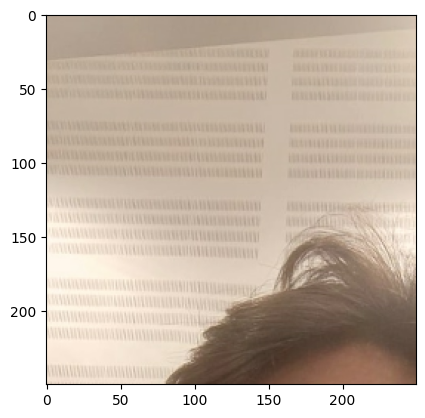

In [23]:
plt.imshow(res[0][0])

In [24]:
def plot_sample_images(start_idx, end_idx, image_samples, coordinates):
    """
    Plots a range of sample images with predicted coordinates marked.

    Parameters:
    start_idx (int): The starting index of the samples to be plotted.
    end_idx (int): The ending index of the samples to be plotted.
    image_samples (list or ndarray): The list or array of test sample images.
    coordinates (list or ndarray): The list or array of predicted coordinates.

    """
    ncols = end_idx - start_idx
    fig, ax = plt.subplots(
        ncols=ncols, figsize=(5 * ncols, 5)
    )  # Adjusted figsize to scale with number of columns
    for idx in range(start_idx, end_idx):
        # Create a writable copy of the sample image
        sample_image = image_samples[idx].copy()
        sample_coords = coordinates[idx]

        # Draw the circles on the image
        cv2.circle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)),
            2,
            (255, 0, 0),
            -1,
        )
        cv2.circle(
            sample_image,
            tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)),
            2,
            (0, 255, 0),
            -1,
        )

        # Show the image
        ax[idx - start_idx].imshow(sample_image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


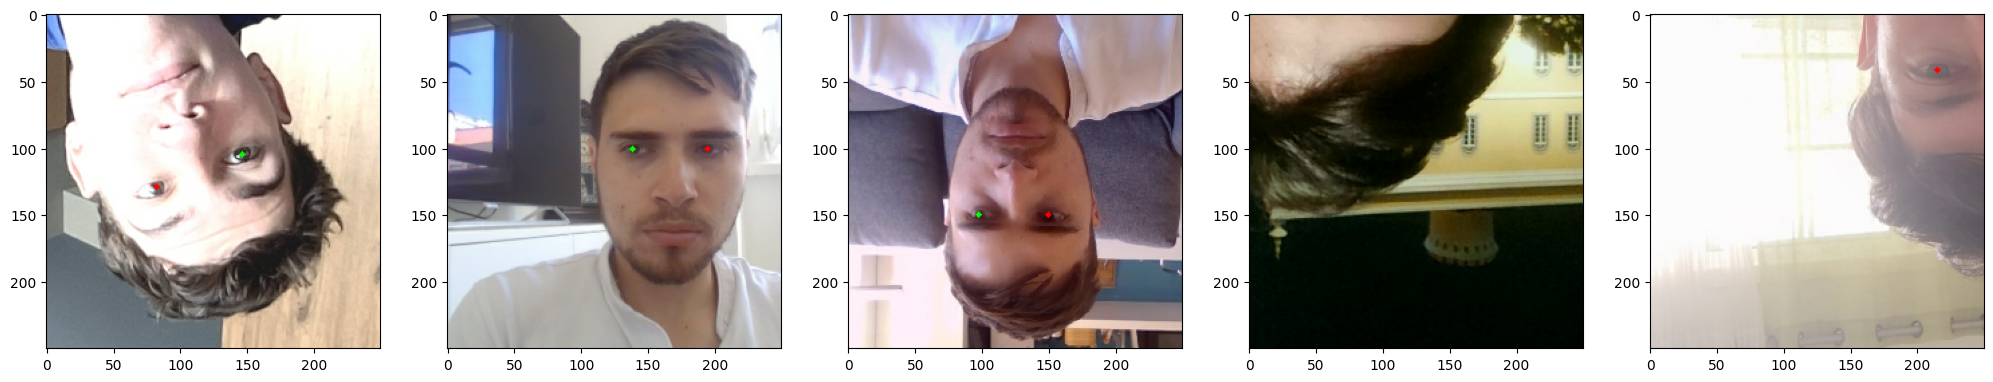

In [25]:
plot_sample_images(10, 15, res[0], res[1][0])

# 3. Build Model


## A. ResNet


### 3.1 Create Neural Network


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [27]:
model = Sequential(
    [
        Input(shape=(250, 250, 3)),
        ResNet152V2(include_top=False, input_shape=(250, 250, 3)),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(256, 3, 2, padding="same", activation="relu"),
        Conv2D(256, 2, 2, activation="relu"),
        Dropout(0.05),
        Conv2D(4, 2, 2),
        Reshape((4,)),
    ]
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer


In [29]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [30]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions


In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
X.shape

(16, 250, 250, 3)

In [33]:
scores = model.predict(X)

2024-04-24 16:53:20.965013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


In [34]:
scores

array([[-0.13570255, -0.2085783 ,  0.37642333, -0.09965794],
       [-1.338055  , -0.43558353,  0.96410406,  0.43001148],
       [-0.43444782, -0.49882916,  0.41124135,  0.1703313 ],
       [-0.05156149,  0.01287073, -0.33559632, -0.4609166 ],
       [-0.9572118 , -0.17641947,  0.69674575, -0.26364207],
       [-0.26039845, -0.09322762,  0.15595047,  0.11007319],
       [-0.2552175 , -0.80265504,  0.6576266 ,  0.24613494],
       [-0.46185058,  0.16884905, -0.06557427, -0.2389922 ],
       [ 0.03716189, -0.09109026,  0.3522729 , -0.40335193],
       [-0.05168194, -0.42858356,  0.29477596,  0.23863462],
       [-0.70927787, -0.42214268,  0.29639375,  0.31828094],
       [-1.6899391 ,  0.7093463 ,  0.9162423 ,  0.62104034],
       [-1.1447877 , -0.8918013 ,  0.8592347 ,  0.52796304],
       [-1.2572068 , -0.31938952,  0.56869394,  0.09755738],
       [-0.2625155 , -0.51953745,  0.7310583 ,  0.5080291 ],
       [-1.247864  , -0.10149854,  0.520013  , -0.3444029 ]],
      dtype=float32)

### 3.4 Train the Model


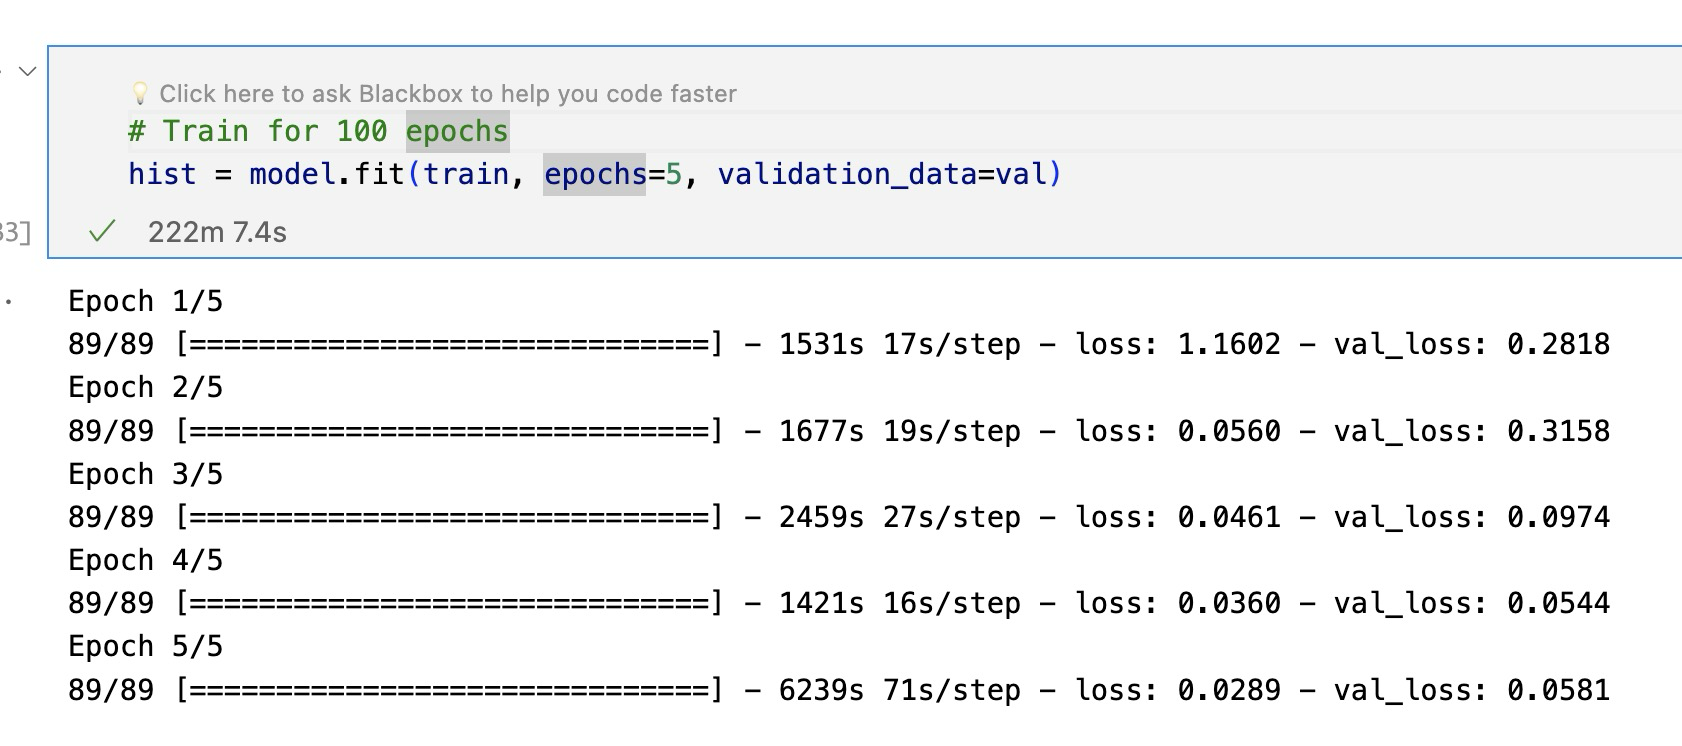

### from the video:

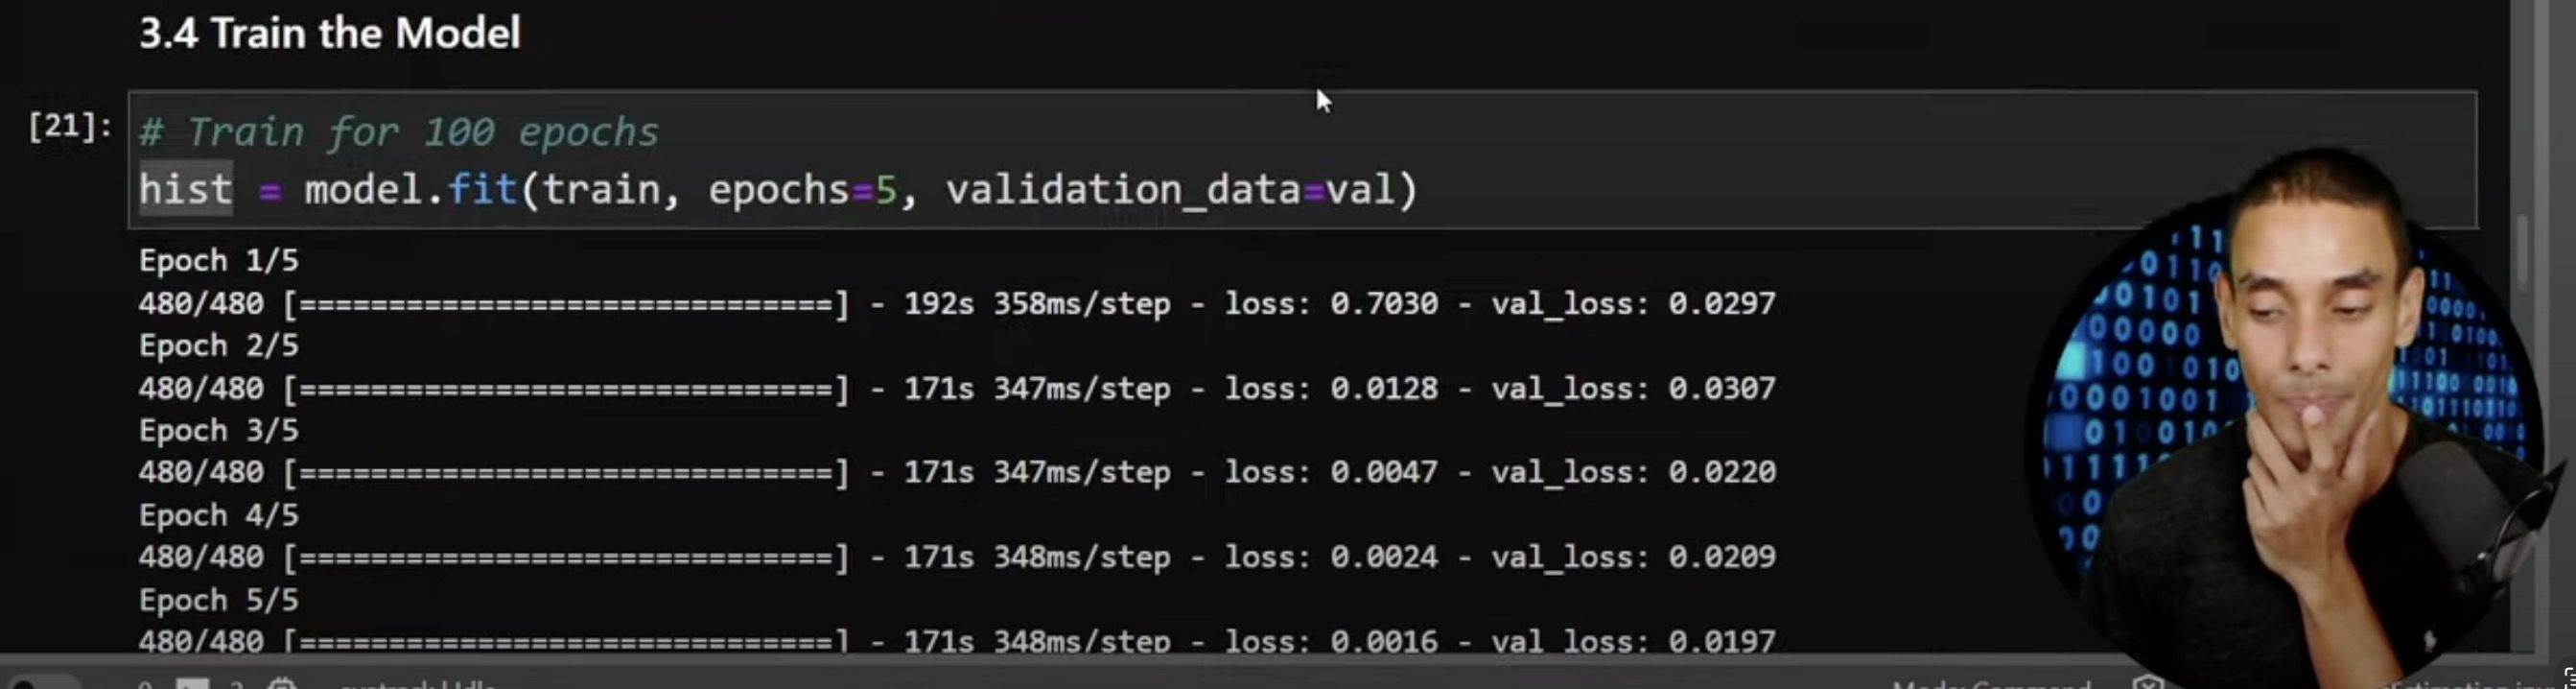


In [37]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2024-04-24 16:57:17.302386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-24 16:57:17.302438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-24 16:57:17.302504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-24 16:57:17.302516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


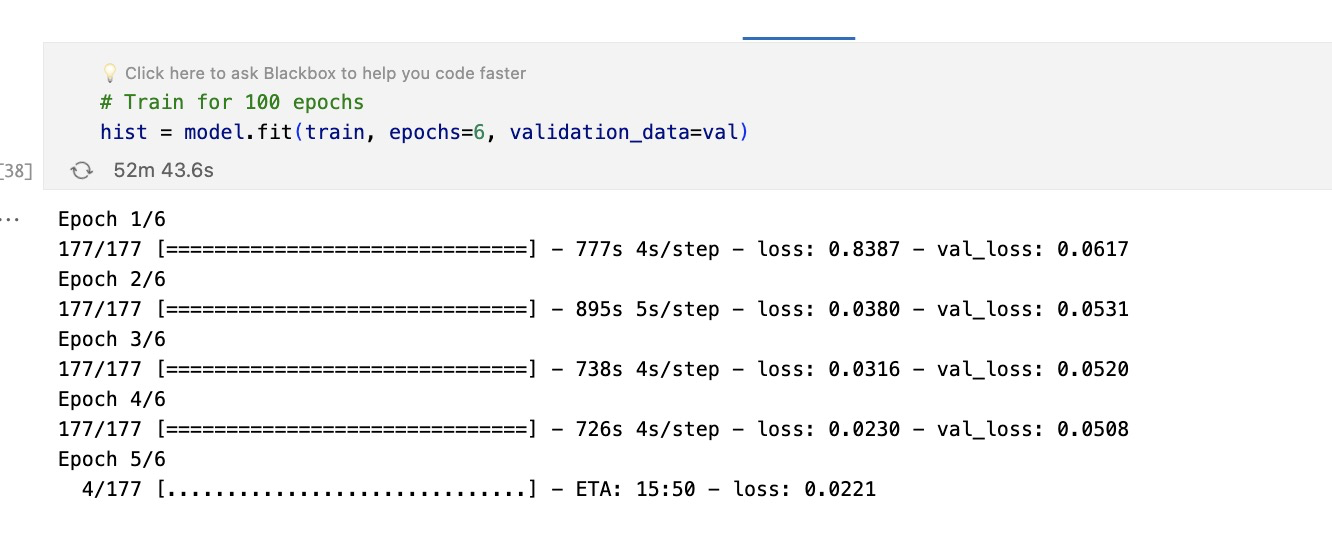


In [38]:
# Train for 100 epochs
hist = model.fit(train, epochs=6, validation_data=val)

Epoch 1/6


177/177 [==============================] - 777s 4s/step - loss: 0.8387 - val_loss: 0.0617
Epoch 2/6
177/177 [==============================] - 895s 5s/step - loss: 0.0380 - val_loss: 0.0531
Epoch 3/6
177/177 [==============================] - 738s 4s/step - loss: 0.0316 - val_loss: 0.0520
Epoch 4/6
177/177 [==============================] - 726s 4s/step - loss: 0.0230 - val_loss: 0.0508
Epoch 5/6
177/177 [==============================] - 6155s 35s/step - loss: 0.0186 - val_loss: 0.0509
Epoch 6/6
177/177 [==============================] - 761s 4s/step - loss: 0.0138 - val_loss: 0.0547


## B. VGG


### 4.1 Create Neural Network


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG-16 model without the top layer, adapted to your input size
base_model_vgg = VGG16(
    weights="imagenet", include_top=False, input_shape=(250, 250, 3))

# Freeze the layers of the base model to preserve the learned features
for layer in base_model_vgg.layers:
    layer.trainable = False

# Create the model with custom layers specifically for iris detection
model_vgg = Sequential(
    [
        base_model_vgg,
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(512, 3, padding="same", activation="relu"),
        MaxPooling2D(2),
        Conv2D(256, 3, padding="same", activation="relu"),
        Conv2D(256, 3, 2, padding="same", activation="relu"),
        Dropout(0.05),  # Moderate dropout to prevent overfitting
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.1),
        # Outputs normalized coordinates for the iris
        Dense(4, activation="sigmoid"),
    ]
)

# model_vgg.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

# Compile the model_vgg with an appropriate optimizer and loss function for regression
model_vgg.compile(optimizer=optimizer, loss=loss)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 256)         1179904   
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 256)         590080    
                                                      

### 4.2 Setup Losses and Optimizer


In [36]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

# Compile the model_vgg with an appropriate optimizer and loss function for regression
model_vgg.compile(optimizer=optimizer, loss=loss)

# history_vgg = model_vgg.fit(train, epochs=5, validation_data=val)

### 4.3 Train the model


In [37]:
history_vgg = model_vgg.fit(train, epochs=5, validation_data=val)

Epoch 1/5
89/89 [==============================] - 86s 941ms/step - loss: 0.1510 - val_loss: 0.1403
Epoch 2/5
89/89 [==============================] - 82s 895ms/step - loss: 0.1517 - val_loss: 0.1403
Epoch 3/5
89/89 [==============================] - 83s 907ms/step - loss: 0.1517 - val_loss: 0.1403
Epoch 4/5
89/89 [==============================] - 86s 944ms/step - loss: 0.1517 - val_loss: 0.1403
Epoch 5/5
89/89 [==============================] - 87s 959ms/step - loss: 0.1517 - val_loss: 0.1403


## Tuner Search


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2900)
train = train.batch(16)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1700)
test = test.batch(16)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(16)
val = val.prefetch(4)


def build_model(hp):
    model_type = hp.Choice("model_type", ["VGG16", "ResNet152V2"])  # "ResNet152V2"  #

    if model_type == "VGG16":
        base_model = tf.keras.applications.VGG16(
            include_top=False, input_shape=(250, 250, 3), weights="imagenet"
        )
    else:
        base_model = tf.keras.applications.ResNet152V2(
            include_top=False, input_shape=(250, 250, 3), weights="imagenet"
        )

    base_model.trainable = not hp.Boolean("freeze_layers")  # True

    model = keras.Sequential(
        [
            base_model,
            layers.Conv2D(512, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(2),
            layers.Flatten(),
            layers.Dense(
                hp.Int("dense_units", min_value=32, max_value=512, step=32),
                activation="relu",
            ),
            layers.Dropout(
                hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)
            ),
            layers.Dense(4, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.legacy.Adam(
            learning_rate=hp.Float(
                "learning_rate", min_value=0.001, max_value=0.2, sampling="LOG"
            )
        ),
        loss="mean_squared_error",
    )

    return model


# Create a tuner. You can specify the objective and the number of trials.
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="my_dir",
    project_name="model_tuning",
)

# Assuming train and val datasets are tf.data.Dataset objects properly defined
train_data, val_data = train, val  # Example placeholders

tuner.search(train_data, epochs=5, validation_data=val_data)

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_37126/1826088016.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from my_dir/model_tuning/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
VGG16             |VGG16             |model_type
False             |True              |freeze_layers
32                |352               |dense_units
0.3               |0.6               |dropout_rate
0.066734          |0.011468          |learning_rate

Epoch 1/5


2024-04-26 12:43:14.343172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 533s 3s/step - loss: 0.3369 - val_loss: 0.2737
Epoch 2/5
177/177 [==============================] - 530s 3s/step - loss: 0.3409 - val_loss: 0.2737
Epoch 3/5
177/177 [==============================] - 514s 3s/step - loss: 0.3439 - val_loss: 0.2737
Epoch 4/5
177/177 [==============================] - 532s 3s/step - loss: 0.3472 - val_loss: 0.2737
Epoch 5/5
177/177 [==============================] - ETA: 0s - loss: 0.3438

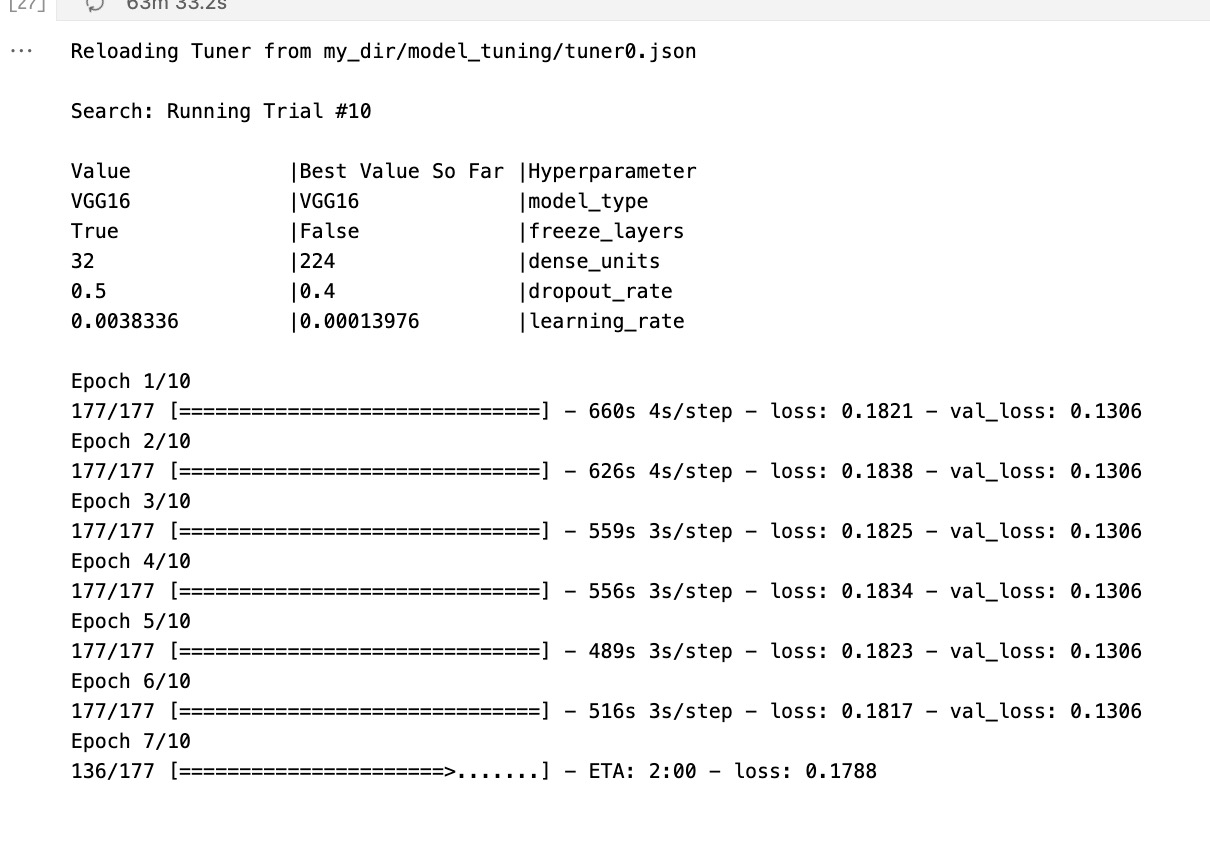


In [ ]:
# Retrieve the best model.
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model(best_hp)
model.fit(train_data, epochs=6, validation_data=val_data)


# Test predictions
def plot_sample_images(start, end, images, predictions):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 2))
    for i in range(start, end):
        plt.subplot(1, end - start, i - start + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {predictions[i]}")
        plt.axis("off")
    plt.show()


test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
plot_sample_images(0, 4, test_sample[0], yhat)

# 4. Review Performance


### 4.1 View Loss Plots


In [109]:
hist.history

{'loss': [3.59428334236145,
  0.05803845450282097,
  0.043373581022024155,
  0.03364357724785805,
  0.030716031789779663,
  0.026621025055646896,
  0.02246912196278572,
  0.020609933882951736],
 'val_loss': [1.1850643157958984,
  0.09675299376249313,
  0.06696769595146179,
  0.09008098393678665,
  0.06304404139518738,
  0.06086735054850578,
  0.06306864321231842,
  0.06551752984523773]}

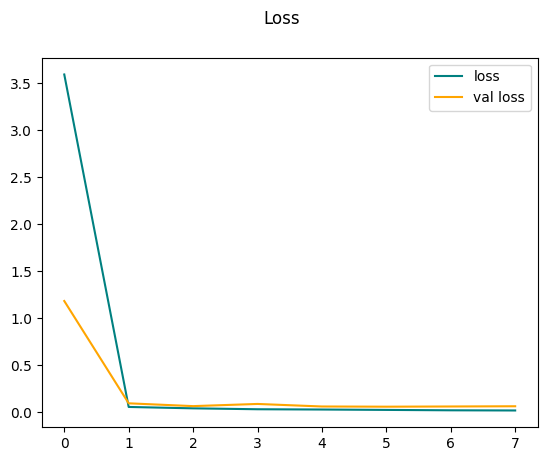

In [110]:
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val loss")
plt.suptitle("Loss")
plt.legend()
plt.show()

### 4.2. Make Predictions on Test


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


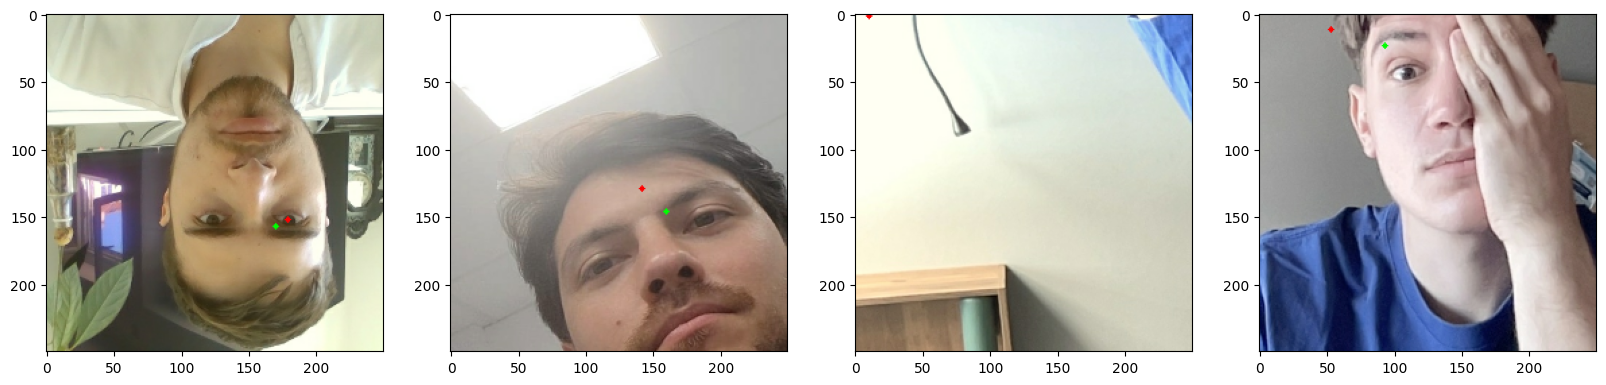

In [62]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
plot_sample_images(0, 4, test_sample[0], yhat)

In [60]:
# plot_sample_images(0, 4, test_sample[0], yhat)

In [113]:
# test_data = test.as_numpy_iterator()
# test_sample = test_data.next()
# yhat = model.predict(test_sample[0])


# fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# for idx in range(4):
#     # Create a writable copy of the sample image
#     sample_image = test_sample[0][idx].copy()
#     sample_coords = yhat[idx]

#     cv2.circle(
#         sample_image,
#         tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)),
#         2,
#         (255, 0, 0),
#         -1
#     )
#     cv2.circle(
#         sample_image,
#         tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)),
#         2,
#         (0, 255, 0),
#         -1
#     )

#     ax[idx].imshow(sample_image)

### 4.3. Save the Model


### **first trained model is uploaded on my onedrive as it is to big to store on github. just download it and put it in the same folder as the code. It was produced with the same code in this notebook.**

link: https://1drv.ms/u/s!Ap9X0H2ysg0VhMB8FSJk6GIEBS_hHA?e=HqGfzl


In [118]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "eyetrackerresnet{}.h5".format(timestamp)

In [119]:
model.save(filename)

/Users/peterfalterbaum/anaconda3/envs/ProgrammingDS/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
from tensorflow.keras.models import load_model

model = load_model("eyetrackerresnet20240422_205952.h5")

In [ ]:
model.predict(test_sample[0])

1/1 [==============================] - 5s 5s/step


array([[-0.01595877, -0.02694788,  0.06226623,  0.0225804 ],
       [ 0.44576833,  0.37046853,  0.39235884,  0.29783845],
       [ 0.01832629,  0.02076698, -0.00251424, -0.00230052],
       [ 0.220974  ,  0.23545521,  0.4078232 ,  0.43336695],
       [ 0.20460549,  0.64565766,  0.28342614,  0.60599875],
       [ 0.03083288,  0.27387962,  0.08495668,  0.1826602 ],
       [ 0.01428997,  0.32917044,  0.14770171,  0.34455526],
       [-0.0121689 , -0.02231944,  0.05234042,  0.0180831 ],
       [ 0.12549408, -0.01007451,  0.16232157,  0.11530594],
       [-0.00085108, -0.00136209,  0.06009679,  0.02534008],
       [-0.00075612,  0.00130264,  0.05813616,  0.02853411],
       [-0.00890324, -0.02287058,  0.05417106,  0.01394499],
       [ 0.65833634,  0.40241167,  0.7159685 ,  0.44566643],
       [ 0.35158968,  0.5557193 ,  0.50401634,  0.65830475],
       [ 0.3101913 ,  0.13408192,  0.5786302 ,  0.35086623],
       [ 0.1747661 ,  0.18116194,  0.5269819 ,  0.5201608 ]],
      dtype=float32)

# 5. Real Time Detection


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()

    frame = frame[50:500, 50:500, :]
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250, 250))

    yhat = model.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[0, :4]

    cv2.circle(
        frame,
        tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
        2,
        (255, 0, 0),
        -1,
    )
    cv2.circle(
        frame,
        tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
        2,
        (0, 255, 0),
        -1,
    )

    cv2.imshow("EyeTrack", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()